In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import re

In [2]:

# def summarize_session(predictions_csv_path: Path, data_root: Path, scratch_dir: Path, tolerance=0.01):
#     """
#     Runs the full pipeline on one session and returns a summary dict.
#     Saves the per-session summary figure into scratch_dir/<session_id>_summary.png.
    
#     Parameters:
#     - predictions_csv_path: Path to the predictions CSV (LP_csv).
#     - data_root: root folder containing behavior_<…> session subfolders.
#     - scratch_dir: folder to write summary figures and CSV.
#     """
#     from aind_dynamic_foraging_behavior_video_analysis.kinematics.kinematics_nwb_utils import get_nwb_file
#     from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
#         load_keypoints_from_csv, find_behavior_videos_folder,
#         integrate_keypoints_with_video_time, mask_keypoint_data,
#         kinematics_filter, segment_movements_trimnans,
#         annotate_trials_in_kinematics, annotate_licks_in_kinematics,
#         assign_movements_to_licks, aggregate_tongue_movements,
#         add_lick_metadata_to_movements, get_session_name_from_path
#     )
#     import aind_dynamic_foraging_data_utils.nwb_utils as nwb_utils
#     from aind_dynamic_foraging_basic_analysis.licks import annotation

#     # 1) Determine session_id from predictions path
#     lp_csv = predictions_csv_path
#     session_id = get_session_name_from_path(str(lp_csv))
#     print(f"\n=== Processing session: {session_id} ===")
#     print(f"Predictions CSV: {lp_csv}")

#     # 2) Load keypoints
#     kps = load_keypoints_from_csv(str(lp_csv))
#     print(f"Loaded keypoints: {len(kps)} raw frames")

#     # 3) Locate synced video CSV via session_id under data_root
#     videos_folder = find_behavior_videos_folder(str(data_root / session_id))
#     if videos_folder is None:
#         raise FileNotFoundError(f"Videos folder not found for session {session_id}")
#     video_csv = Path(videos_folder) / "bottom_camera.csv"
#     if not video_csv.exists():
#         raise FileNotFoundError(f"Expected video CSV at {video_csv}")
#     print(f"Found video CSV: {video_csv}")

#     # 4) Sync keypoints to video time
#     kps_trim, _ = integrate_keypoints_with_video_time(str(video_csv), kps)
#     print(f"Synced keypoints: {len(kps_trim)} frames after trim")

#     # 5) Movement segmentation
#     tongue_masked = mask_keypoint_data(kps_trim, 'tongue_tip_center', confidence_threshold=0.90)
#     tongue_filtered = kinematics_filter(tongue_masked, cutoff_freq=50, filter_order=4, filter_kind='cubic')
#     tongue_seg = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)
#     print(f"Segmented {tongue_seg['movement_id'].nunique()} unique movements")

#     # 6) Load and annotate NWB
#     nwb = get_nwb_file(session_id)
#     nwb.df_events = nwb_utils.create_events_df(nwb)
#     nwb.df_trials = nwb_utils.create_df_trials(nwb)
#     nwb.df_licks = annotation.annotate_licks(nwb)
#     print(f"NWB load: {len(nwb.df_trials)} trials, {len(nwb.df_licks)} licks")

#     tongue_annot = annotate_trials_in_kinematics(tongue_seg, nwb.df_trials)
#     tongue_kin = annotate_licks_in_kinematics(tongue_annot, nwb.df_licks, tolerance=tolerance)
#     nwb.df_licks = assign_movements_to_licks(tongue_kin, nwb.df_licks)
#     print("Annotated kinematics with trials & licks")

#     # 7) Aggregate movements
#     tongue_movs = aggregate_tongue_movements(tongue_kin, kps_trim)
#     tongue_movs = add_lick_metadata_to_movements(
#         tongue_movs, nwb.df_licks, fields=['cue_response','rewarded','event']
#     )
#     print(f"Aggregated movements DF shape: {tongue_movs.shape}")

#     # 8) Coverage
#     total_licks = len(nwb.df_licks)
#     with_mov = nwb.df_licks['nearest_movement_id'].notna().sum()
#     coverage_pct = 100 * with_mov / total_licks if total_licks else np.nan
#     print(f"Coverage: {coverage_pct:.1f}% ({with_mov}/{total_licks})")

#     # 9) Quality metrics
#     lick_movs = tongue_movs[tongue_movs['has_lick']]
#     quality = {
#         'mean_n_datapoints': lick_movs['n_datapoints'].mean(),
#         'mean_duration_s':   lick_movs['duration'].mean(),
#         'mean_dropped_pct':  lick_movs['dropped_frames_pct'].mean(),
#     }
#     print(f"Quality metrics: {quality}")

#     # 10) Summary figure
#     fig = plt.figure(constrained_layout=True, figsize=(12,8))
#     gs = fig.add_gridspec(2,3)
#     ax_cov  = fig.add_subplot(gs[0,:2])
#     ax_scat = fig.add_subplot(gs[0,2])
#     ax_h0   = fig.add_subplot(gs[1,0])
#     ax_h1   = fig.add_subplot(gs[1,1])
#     ax_h2   = fig.add_subplot(gs[1,2])

#     ax_cov.bar(['covered','missed'], [coverage_pct, 100-coverage_pct], color=['green','red'])
#     ax_cov.set_ylim(0,100); ax_cov.set_title(f"{session_id}\nCoverage (%)")

#     ax_scat.scatter(lick_movs['duration'], lick_movs['dropped_frames_pct'], alpha=0.6, edgecolor='k')
#     ax_scat.set_xlabel('Duration (s)'); ax_scat.set_ylabel('Dropped %')
#     ax_scat.set_title('Duration vs Drop%')

#     ax_h0.hist(lick_movs['n_datapoints'], bins=30); ax_h0.set(title='Frames', xlabel='n_dp')
#     ax_h1.hist(lick_movs['duration'], bins=30);      ax_h1.set(title='Duration', xlabel='s')
#     ax_h2.hist(lick_movs['dropped_frames_pct'], bins=30); ax_h2.set(title='Dropped %', xlabel='%')

#     out_png = scratch_dir / f"{session_id}_summary.png"
#     fig.savefig(out_png, dpi=150)
#     plt.close(fig)
#     print(f"Saved figure: {out_png}")

#     return {
#         'session_id': session_id,
#         'total_licks': total_licks,
#         'coverage_pct': coverage_pct,
#         **quality,
#         'summary_figure': str(out_png)
#     }


In [3]:
# # Path to the predictions CSV (from the processed folder)
# pred_csv = Path("/root/capsule/data/behavior_751004_2024-12-23_14-19-57_processed_2025-07-10_06-34-56/pred_outputs/video_preds/bottom_camera_predictions.csv")

# # Root folder where the raw behavior_<...> session folders live
# data_root = Path("/root/capsule/data")

# # Scratch folder to save figures/summaries
# scratch = Path("/root/capsule/scratch/session_analysis")
# scratch.mkdir(exist_ok=True, parents=True)

# # Run the session summary
# summary = summarize_session(pred_csv, data_root, scratch)

In [4]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

def generate_tongue_dfs(predictions_csv_path: Path, data_root: Path, tolerance=0.01):
    """
    Runs the full pipeline for one session and returns the NWB object, 
    annotated tongue kinematics, and aggregated tongue movements.

    Parameters
    ----------
    predictions_csv_path : Path
        Path to the predictions CSV (LP_csv).
    data_root : Path
        Root folder containing behavior_<…> session subfolders.
    tolerance : float, optional
        Lick-kinematics matching tolerance (default 0.01).

    Returns
    -------
    tuple : (nwb, tongue_kin, tongue_movs)
        nwb: NWBFile object with annotated licks/trials added
        tongue_kin: frame-level annotated tongue kinematics (DataFrame)
        tongue_movs: movement-level aggregated tongue movements (DataFrame)
    """
    # === Imports inside so function is self-contained ===
    from aind_dynamic_foraging_behavior_video_analysis.kinematics.kinematics_nwb_utils import get_nwb_file
    from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
        load_keypoints_from_csv, find_behavior_videos_folder,
        integrate_keypoints_with_video_time, mask_keypoint_data,
        kinematics_filter, segment_movements_trimnans,
        annotate_trials_in_kinematics, annotate_licks_in_kinematics,
        assign_movements_to_licks, aggregate_tongue_movements,
        add_lick_metadata_to_movements, get_session_name_from_path
    )
    import aind_dynamic_foraging_data_utils.nwb_utils as nwb_utils
    from aind_dynamic_foraging_basic_analysis.licks import annotation

    # === 1) Session detection ===
    lp_csv = predictions_csv_path
    session_id = get_session_name_from_path(str(lp_csv))
    print(f"\n=== Generating tongue data for session: {session_id} ===")
    print(f"Predictions CSV: {lp_csv}")

    # === 2) Load keypoints ===
    kps = load_keypoints_from_csv(str(lp_csv))
    print(f"Loaded keypoints: {len(kps)} raw dataframes")

    # === 3) Locate synced video CSV ===
    videos_folder = find_behavior_videos_folder(str(data_root / session_id))
    if videos_folder is None:
        raise FileNotFoundError(f"Videos folder not found for session {session_id}")
    video_csv = Path(videos_folder) / "bottom_camera.csv"
    if not video_csv.exists():
        raise FileNotFoundError(f"Expected video CSV at {video_csv}")
    print(f"Found video CSV: {video_csv}")

    # === 4) Sync keypoints to video time ===
    kps_trim, _ = integrate_keypoints_with_video_time(str(video_csv), kps)
    print(f"Synced keypoints")

    # === 5) Tongue movement segmentation ===
    tongue_masked = mask_keypoint_data(kps_trim, 'tongue_tip_center', confidence_threshold=0.90)
    tongue_filtered = kinematics_filter(tongue_masked, cutoff_freq=50, filter_order=4, filter_kind='cubic')
    tongue_seg = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)
    print(f"Segmented {tongue_seg['movement_id'].nunique()} unique movements")

    # === 6) Load NWB and annotate ===
    nwb = get_nwb_file(session_id)
    nwb.df_events = nwb_utils.create_events_df(nwb)
    nwb.df_trials = nwb_utils.create_df_trials(nwb)
    nwb.df_licks = annotation.annotate_licks(nwb)
    print(f"NWB load: {len(nwb.df_trials)} trials, {len(nwb.df_licks)} licks")

    tongue_annot = annotate_trials_in_kinematics(tongue_seg, nwb.df_trials)
    tongue_kin = annotate_licks_in_kinematics(tongue_annot, nwb.df_licks, tolerance=tolerance)
    nwb.df_licks = assign_movements_to_licks(tongue_kin, nwb.df_licks)
    print("Annotated kinematics with trials & licks")

    # === 7) Aggregate movements ===
    tongue_movs = aggregate_tongue_movements(tongue_kin, kps_trim)
    tongue_movs = add_lick_metadata_to_movements(
        tongue_movs, nwb.df_licks, fields=['cue_response','rewarded','event']
    )
    print(f"Aggregated movements DF shape: {tongue_movs.shape}")

    return nwb, tongue_kin, tongue_movs


In [5]:
# Path to the predictions CSV (from the processed folder)
pred_csv = Path("/root/capsule/data/behavior_751004_2024-12-23_14-19-57_processed_2025-07-10_06-34-56/pred_outputs/video_preds/bottom_camera_predictions.csv")

# Root folder where the raw behavior_<...> session folders live
data_root = Path("/root/capsule/data")

nwb, tongue_kins, tongue_movs = generate_tongue_dfs(pred_csv, data_root)


=== Generating tongue data for session: behavior_751004_2024-12-23_14-19-57 ===
Predictions CSV: /root/capsule/data/behavior_751004_2024-12-23_14-19-57_processed_2025-07-10_06-34-56/pred_outputs/video_preds/bottom_camera_predictions.csv
keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Loaded keypoints: 11 raw dataframes
Found video CSV: /root/capsule/data/behavior_751004_2024-12-23_14-19-57/behavior-videos/bottom_camera.csv
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 3338382 to 3338381
Synced keypoints
Segmented 5817 unique movements
NWB file not found for 751004 on 2024-12-23. Generating it now...
Generated NWB file: /root/capsule/scratch/behavior_751004_2024-12-23_14-19-57/751004_2024-12-23_14-20-03.nwb
Timestamps are adjusted such that `_in_session` ti

/opt/conda/lib/python3.9/site-packages/aind_dynamic_foraging_data_utils/nwb_utils.py:506: UserWarning: Reward before choice time.                 This is likely due to manual rewards not being recorded in sessions from 2024
  warnings.warn("Reward before choice time. \


NWB load: 579 trials, 5397 licks
Annotated kinematics with trials & licks
Aggregated movements DF shape: (5817, 37)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def analyze_tongue_movement_quality(
    nwb, tongue_movs, session_id: str, scratch_dir: Path
):
    """
    Analyze lick-associated tongue movement quality and generate a summary figure.

    Parameters
    ----------
    nwb : NWBFile-like object
        Must contain df_licks with 'nearest_movement_id'.
    tongue_movs : pd.DataFrame
        Aggregated tongue movements (output of aggregate_tongue_movements).
    session_id : str
        Session identifier for labeling and saving.
    scratch_dir : Path
        Directory to save the output figure.

    Returns
    -------
    dict
        Summary quality metrics and saved figure path.
    """
    # --- 1) Coverage ---
    total_licks = len(nwb.df_licks)
    with_mov = nwb.df_licks['nearest_movement_id'].notna().sum()
    coverage_pct = 100 * with_mov / total_licks if total_licks else np.nan
    print(f"Coverage: {coverage_pct:.1f}% ({with_mov}/{total_licks})")

    # --- 2) Quality metrics ---
    lick_movs = tongue_movs[tongue_movs['has_lick']]
    quality = {
        'mean_n_datapoints': lick_movs['n_datapoints'].mean(),
        'mean_duration_s':   lick_movs['duration'].mean(),
        'mean_dropped_pct':  lick_movs['dropped_frames_pct'].mean(),
    }
    print(f"Quality metrics: {quality}")

    # --- 3) Summary figure ---
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    gs = fig.add_gridspec(2, 3)

    ax_cov = fig.add_subplot(gs[0, :2])
    ax_scat = fig.add_subplot(gs[0, 2])
    ax_h0 = fig.add_subplot(gs[1, 0])
    ax_h1 = fig.add_subplot(gs[1, 1])
    ax_h2 = fig.add_subplot(gs[1, 2])

    ax_cov.bar(['covered', 'missed'],
               [coverage_pct, 100 - coverage_pct],
               color=['green', 'red'])
    ax_cov.set_ylim(0, 100)
    ax_cov.set_title(f"{session_id}\nCoverage (%)")

    ax_scat.scatter(lick_movs['duration'],
                    lick_movs['dropped_frames_pct'],
                    alpha=0.6, edgecolor='k')
    ax_scat.set_xlabel('Duration (s)')
    ax_scat.set_ylabel('Dropped %')
    ax_scat.set_title('Duration vs Drop%')

    ax_h0.hist(lick_movs['n_datapoints'], bins=30)
    ax_h0.set(title='Frames', xlabel='n_dp')
    ax_h1.hist(lick_movs['duration'], bins=30)
    ax_h1.set(title='Duration', xlabel='s')
    ax_h2.hist(lick_movs['dropped_frames_pct'], bins=30)
    ax_h2.set(title='Dropped %', xlabel='%')

    out_png = scratch_dir / f"{session_id}_summary.png"
    fig.savefig(out_png, dpi=150)
    plt.close(fig)
    print(f"Saved figure: {out_png}")

    return {
        'session_id': session_id,
        'total_licks': total_licks,
        'coverage_pct': coverage_pct,
        **quality,
        'summary_figure': str(out_png)
    }


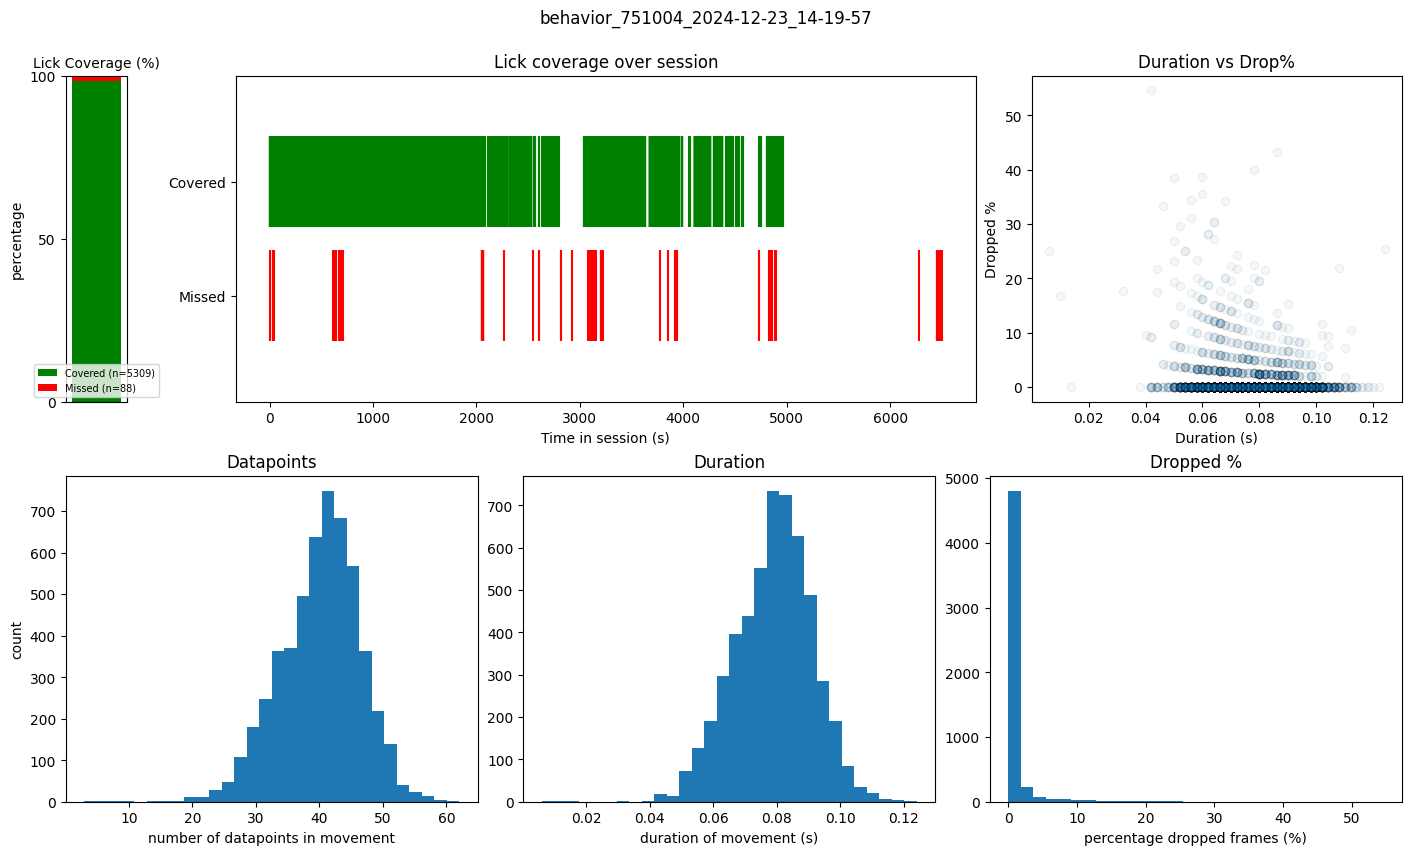

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# --- Example coverage calculations (replace with real) ---
total_licks = len(nwb.df_licks)
with_mov = nwb.df_licks['nearest_movement_id'].notna().sum()
coverage_pct = 100 * with_mov / total_licks if total_licks else np.nan

lick_movs = tongue_movs[tongue_movs['has_lick']]
lick_times = nwb.df_licks['timestamps']  # or time_in_session
has_mov = nwb.df_licks['nearest_movement_id'].notna()
covered_times = lick_times[has_mov]
missed_times = lick_times[~has_mov]

# --- FIGURE LAYOUT ---
fig = plt.figure(constrained_layout=True, figsize=(14, 8))
parent_gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])  # top row, bottom row

# Top row: skinny coverage, wide raster, scatter
gs_top = parent_gs[0].subgridspec(1, 4, width_ratios=[0.5, 2.5, 2.0, 2.0])
gs_top = parent_gs[0].subgridspec(1, 3, width_ratios=[0.5, 6, 3])


# Bottom row: 3 equal-width histograms
gs_bottom = parent_gs[1].subgridspec(1, 3, width_ratios=[1, 1, 1])

# --- AXES ---
ax_cov = fig.add_subplot(gs_top[0, 0])
ax_raster = fig.add_subplot(gs_top[0, 1])
ax_scat = fig.add_subplot(gs_top[0, 2])
ax_h0 = fig.add_subplot(gs_bottom[0, 0])
ax_h1 = fig.add_subplot(gs_bottom[0, 1])
ax_h2 = fig.add_subplot(gs_bottom[0, 2])

# --- COVERAGE BAR (stacked, with n in legend) ---
n_missed = total_licks - with_mov
ax_cov.bar(0, coverage_pct, color='green', label=f'Covered (n={with_mov})')
ax_cov.bar(0, 100 - coverage_pct, bottom=coverage_pct,
           color='red', label=f'Missed (n={n_missed})')

ax_cov.set_ylim(0, 100)
ax_cov.set_xlim(-0.5, 0.5)
ax_cov.set_xticks([])
ax_cov.set_yticks([0, 50, 100])
ax_cov.set_ylabel('percentage')
ax_cov.set_title("Lick Coverage (%)", fontsize=10)
ax_cov.legend(fontsize=7, loc='lower center')


# --- RASTER ---
ax_raster.eventplot(
    [covered_times, missed_times],
    lineoffsets=[1, 0], linelengths=0.8,
    colors=['green', 'red']
)
ax_raster.set_yticks([1, 0])
ax_raster.set_yticklabels(['Covered', 'Missed'])
ax_raster.set_xlabel('Time in session (s)')
ax_raster.set_title(f'Lick coverage over session')

# --- SCATTER ---
ax_scat.scatter(lick_movs['duration'], lick_movs['dropped_frames_pct'],
                alpha=0.05, edgecolor='k')
ax_scat.set_xlabel('Duration (s)')
ax_scat.set_ylabel('Dropped %')
ax_scat.set_title('Duration vs Drop%')

# --- HISTOGRAMS ---
ax_h0.hist(lick_movs['n_datapoints'], bins=30)
ax_h0.set(title='Datapoints', xlabel='number of datapoints in movement', ylabel='count')

ax_h1.hist(lick_movs['duration'], bins=30)
ax_h1.set(title='Duration', xlabel='duration of movement (s)')

ax_h2.hist(lick_movs['dropped_frames_pct'], bins=30)
ax_h2.set(title='Dropped %', xlabel='percentage dropped frames (%)')

plt.suptitle(f'{session_id}', y=1.05)


plt.show()
